In [1]:
!pip install -q -U watermark

In [2]:
!pip install transformers

In [3]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

numpy       : 1.21.5
pandas      : 1.3.5
torch       : 1.10.0+cu111
transformers: 4.17.0



In [3]:
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 134MB/s]


In [4]:
import transformers
from transformers import BertModel, AutoTokenizer, BertTokenizer, \
     PreTrainedTokenizerFast, AdamW, get_linear_schedule_with_warmup
import torch.nn.functional as F

import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader

# Преобразование данных

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8, 6

In [6]:
df = pd.read_csv("reviews.csv")

In [7]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [8]:
class_names = ['negative', 'neutral', 'positive']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

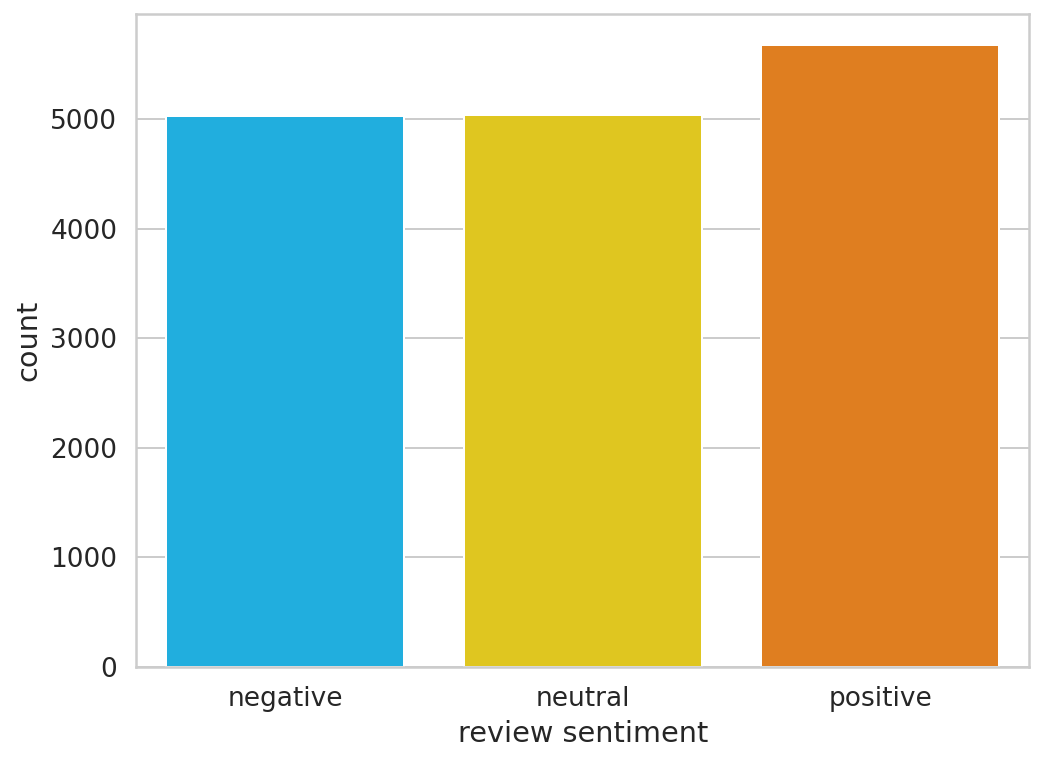

In [9]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

Так как нам нужно обучить 4 модели, то я возьму [TinyBert](http://arxiv.org/abs/1908.08962), и буду дальше его везде использовать. Он маленький и быстрый. Два слоя и hidden size=128. Размер 16 мб!

In [10]:
PRE_TRAINED_MODEL_NAME = 'prajjwal1/bert-tiny'

In [11]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [12]:
class SentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [13]:
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
device

device(type='cuda', index=0)

In [15]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [16]:
df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = SentDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=1
  )

In [19]:
train_encodings = tokenizer(df_train['content'].to_list(),  truncation=True, 
                            padding=True, return_token_type_ids=False, 
                            return_attention_mask=True, max_length=512)
val_encodings = tokenizer(df_val['content'].to_list(),  truncation=True, 
                            padding=True, return_token_type_ids=False, 
                            return_attention_mask=True, max_length=512)
test_encodings = tokenizer(df_test['content'].to_list(), truncation=True, 
                            padding=True, return_token_type_ids=False, 
                            return_attention_mask=True, max_length=512)

In [20]:
train_dataset = SentDataset(train_encodings, df_train['sentiment'].to_list())
val_dataset = SentDataset(val_encodings, df_val['sentiment'].to_list())
test_dataset = SentDataset(test_encodings, df_test['sentiment'].to_list())

# Функция подсчета метрик

Так как классификация мультиклассовая, то будем использовать weighted F1

In [21]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Гиперпараметры для обучения

In [22]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=7,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

# Модель SentimentClassifier

In [23]:
from torch.nn import CrossEntropyLoss

Код скопировал из [открытого кода](https://github.com/huggingface/transformers/blob/v4.17.0/src/transformers/models/bert/modeling_bert.py#L1501)трансформеров (BertForSequenceClassification)

In [25]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):

    super().__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_classes = n_classes
  
  def forward(self,        
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None
    ):

    last_hidden_state, pooled_output = self.bert(input_ids=input_ids,
                        attention_mask=attention_mask,
                        return_dict=False)

    output = self.drop(pooled_output)
    logits = self.out(output)

    loss = None
    if labels is not None:
        loss_fct = CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.n_classes), labels.view(-1))
    output = (logits,)
    return ((loss,) + output) if loss is not None else output

In [26]:
model1 = SentimentClassifier(len(class_names))
model1 = model1.to(device)

Downloading:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
trainer = Trainer(
    model=model1,                        # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics    # metrics to evaluate
)

trainer.train()

In [28]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 787
  Batch size = 16


{'epoch': 7.0,
 'eval_accuracy': 0.7318932655654383,
 'eval_f1': 0.7314690150914519,
 'eval_loss': 0.6737006306648254,
 'eval_precision': 0.7314899348243119,
 'eval_recall': 0.7318932655654383,
 'eval_runtime': 0.9926,
 'eval_samples_per_second': 792.838,
 'eval_steps_per_second': 50.371}

In [29]:
trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")

***** Running Evaluation *****
  Num examples = 788
  Batch size = 16


{'epoch': 7.0,
 'test_accuracy': 0.7296954314720813,
 'test_f1': 0.730731287166518,
 'test_loss': 0.6861445903778076,
 'test_precision': 0.7321550869319734,
 'test_recall': 0.7296954314720813,
 'test_runtime': 0.8619,
 'test_samples_per_second': 914.255,
 'test_steps_per_second': 58.011}

# Sentiment Classifier с CLS

In [30]:
class SentimentClassifierCLS(nn.Module):

  def __init__(self, n_classes):

    super().__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.linear = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)
    self.out = nn.Linear(self.bert.config.hidden_size + 128, n_classes)
    self.n_classes = n_classes
  
  def forward(self,        
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None
    ):

    last_hidden_state, pooled_output = self.bert(
                                  input_ids=input_ids,
                                  attention_mask=attention_mask,
                                  return_dict=False)
    
    cls = last_hidden_state[:,0,:] # CLS token
    pooled_output = self.linear(self.drop(pooled_output)) 
    stacked_layers = torch.hstack([cls, pooled_output]) # CLS + output
    
    logits = self.out(stacked_layers)

    loss = None
    if labels is not None:
        loss_fct = CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.n_classes), labels.view(-1))
    output = (logits,)
    return ((loss,) + output) if loss is not None else output

In [31]:
model2 = SentimentClassifierCLS(len(class_names)) 
model2 = model2.to(device)

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/1ee037c9e1a220d5c814779ffe697080d1e6f5b16

In [ ]:
trainer = Trainer(
    model=model2,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics    # metrics to evaluate
)

trainer.train()

In [33]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 787
  Batch size = 16


{'epoch': 7.0,
 'eval_accuracy': 0.758576874205845,
 'eval_f1': 0.758749187676283,
 'eval_loss': 0.6622886657714844,
 'eval_precision': 0.7590137739611661,
 'eval_recall': 0.758576874205845,
 'eval_runtime': 1.0102,
 'eval_samples_per_second': 779.064,
 'eval_steps_per_second': 49.496}

In [34]:
trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")

***** Running Evaluation *****
  Num examples = 788
  Batch size = 16


{'epoch': 7.0,
 'test_accuracy': 0.7525380710659898,
 'test_f1': 0.7529420948716049,
 'test_loss': 0.6944326758384705,
 'test_precision': 0.7533929690310339,
 'test_recall': 0.7525380710659898,
 'test_runtime': 0.8308,
 'test_samples_per_second': 948.435,
 'test_steps_per_second': 60.18}

# BertForSequenceClassification

In [26]:
from transformers import BertForSequenceClassification
from transformers import BertConfig

model3 = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME)
model3.to(device) 

#Нужно поменять в конфиге число классов на то, которое у нас
config = BertConfig.from_pretrained(PRE_TRAINED_MODEL_NAME)
config.num_labels = len(class_names)

model3 = BertForSequenceClassification(config) 

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

In [ ]:
trainer = Trainer(
    model=model3,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics    # metrics to evaluate
)

trainer.train()

In [28]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 787
  Batch size = 16


{'epoch': 7.0,
 'eval_accuracy': 0.7433290978398983,
 'eval_f1': 0.7441603926453807,
 'eval_loss': 0.713010847568512,
 'eval_precision': 0.7451173611159887,
 'eval_recall': 0.7433290978398983,
 'eval_runtime': 1.0915,
 'eval_samples_per_second': 721.011,
 'eval_steps_per_second': 45.808}

In [29]:
trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")

***** Running Evaluation *****
  Num examples = 788
  Batch size = 16


{'epoch': 7.0,
 'test_accuracy': 0.7068527918781726,
 'test_f1': 0.7073258926817015,
 'test_loss': 0.7899154424667358,
 'test_precision': 0.7079025348839905,
 'test_recall': 0.7068527918781726,
 'test_runtime': 0.8792,
 'test_samples_per_second': 896.225,
 'test_steps_per_second': 56.867}

# Bert + Pooled CLS

In [24]:
class SentimentClassifierCLSPooled(nn.Module):

  def __init__(self, n_classes):

    super().__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.linear = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)
    self.out = nn.Linear(self.bert.config.hidden_size + 128, n_classes)
    self.n_classes = n_classes

  def forward(self,        
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None
    ):

    last_hidden_state, pooled_output, hidden_states = self.bert(
                                                  input_ids=input_ids,
                                                  attention_mask=attention_mask,
                                                  output_hidden_states=True,
                                                  return_dict=False)
    
    # CLS pooling
    all_hidden_states = torch.stack(hidden_states)
    cls_embeddings = torch.mean(all_hidden_states[:, :, 0], 0)
    pooled_output = self.linear(self.drop(pooled_output))
    stacked_layers = torch.hstack([cls_embeddings, pooled_output])

    logits = self.out(stacked_layers)

    loss = None
    if labels is not None:
        loss_fct = CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.n_classes), labels.view(-1))
    output = (logits,)
    return ((loss,) + output) if loss is not None else output

In [25]:
model4 = SentimentClassifierCLSPooled(len(class_names)) 
model4 = model4.to(device)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
trainer = Trainer(
    model=model4,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics    # metrics to evaluate
)

trainer.train()

In [27]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 787
  Batch size = 16


{'epoch': 7.0,
 'eval_accuracy': 0.7420584498094028,
 'eval_f1': 0.7389876329563041,
 'eval_loss': 0.6621106266975403,
 'eval_precision': 0.7374179111578586,
 'eval_recall': 0.7420584498094028,
 'eval_runtime': 0.9346,
 'eval_samples_per_second': 842.108,
 'eval_steps_per_second': 53.501}

In [28]:
trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")

***** Running Evaluation *****
  Num examples = 788
  Batch size = 16


{'epoch': 7.0,
 'test_accuracy': 0.75,
 'test_f1': 0.7495953803920339,
 'test_loss': 0.6738946437835693,
 'test_precision': 0.7499742065954381,
 'test_recall': 0.75,
 'test_runtime': 0.8508,
 'test_samples_per_second': 926.176,
 'test_steps_per_second': 58.768}

# Результаты теста

Как можно видеть, результаты в общем не сильно отличаются друг от друга ни по скорам, ни по времени. В принципе, наверное это из-за того, что Bert маленький и изменение слоев не сильно влияет на обучение. Лучший результат по скорам и времени показывает TinyBert + CLS. 

Однако для дальнейшей проверки на отзывах возьмем последнюю модель (так будет удобнее, потому что я обучал их не за одну сессию и вторая модель не сохранилась). Тем более, F1 у этих моделей одинаковы, а время работы почти не отличается.

|Model|F1|Runime|
|-----|---|----|
|TinyBert Standart|0.73|0.86|
|**TinyBert + CLS**|**0.75**|**0.83**|
|TinyBert Out of the Box|0.71|0.88|
|TinyBert + Pooled CLS|0.75|0.85|

# Проверка на отзывах

5 звезд (лейбл 2)

In [32]:
review_1 = """
Best VPN app ever. The developers are trustworthy enough to trust with your data, I assure you, and the services are very stable. If your hotel WiFi is iffy or your government is trying to slow down Twitter because people are speaking truth there this is for you.
"""

In [33]:
encoding = tokenizer.encode_plus(
  review_1,
  max_length=512,
  add_special_tokens=True, 
  return_token_type_ids=True,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  
  truncation=True
).to('cuda')

In [34]:
model4(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])[0].cpu().detach().numpy().argmax()

0

3 звезды (лейбл 1)

In [35]:
review_2 = """
I love TikTok. However, I've recently had a lot of issues. First, I couldn't use all the filters. I kept getting notifications that the filter couldn't be used on my phone. I can use them all now, but now the captions are messed up. Other reviews say the captions don't show up at all, but I get doub..
"""

In [36]:
encoding = tokenizer.encode_plus(
  review_2,
  max_length=512,
  add_special_tokens=True, 
  return_token_type_ids=True,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  
  truncation=True
).to('cuda')

In [37]:
model4(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])[0].cpu().detach().numpy().argmax()

1

1 звезда (лейбл 0)

In [38]:
review_3 = """
Connection isnt as stable and fast as it must be. Desktop version for Windows doesnt work at all. I wrote to the support, they didnt answer my questions.
"""

In [39]:
encoding = tokenizer.encode_plus(
  review_3,
  max_length=512,
  add_special_tokens=True, 
  return_token_type_ids=True,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  
  truncation=True
).to('cuda')

In [40]:
model4(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])[0].cpu().detach().numpy().argmax()

1

Модель верно определяет 0 и 1 лейб, но 2 почему-то нет (4 и 5 звезд). Попробуем посмотреть на еще одном отзыве.

In [41]:
review_4 = """
Love. This app has been amazing I use the free version use it on my phone and laptop so far no viruses or anything. My phone is a bussniss one which makes it even more important (my own bussniss website) But it has been making my internet slow I do have T-Mobile and 5g it is wicked fast without this VPN but I don't want to pay for one so I choose prontonVPN and there free option what makes my service slow but I don't want viruses so I think it's worth it...
"""

In [42]:
encoding = tokenizer.encode_plus(
  review_4,
  max_length=512,
  add_special_tokens=True, 
  return_token_type_ids=True,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  
  truncation=True
).to('cuda')

Тоже неверно.

In [44]:
model4(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])[0].cpu().detach().numpy().argmax()

0

# Заключение

Tiny Bert неплохо справляется с мульти-классовой классификацией. Он весит мало и работает быстро. Лучший результаты показали модели с манипуляцией с CLS-токенами. При этом, эти результаты сопоставимые.

Однако, при тестировании не реальных отзывах модель с CLS pooling'ом не справляется с положительными отзывами. Мне кажется, что на это может влиять количество эпох. Так, например, увеличение количества эпох сильно повышает результаты (как по времени, так и по скорам). Изначально я обучал модели на 3 эпохах и получал скоры около 60-65. Когда увеличил количество эпох до 7, то скоры возросли до 70-75. 

В качестве эксперимента, я хочу обучить последнюю модель на 15 эпохах и посмотреть, как это отразится на метриках и способности модели определять положительные отзывы.

# Эксперимент с количеством эпох

In [55]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=15,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [56]:
model4 = SentimentClassifierCLSPooled(len(class_names)) 
model4 = model4.to(device)

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/1ee037c9e1a220d5c814779ffe697080d1e6f5b16

In [ ]:
trainer = Trainer(
    model=model4,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics    # metrics to evaluate
)

trainer.train()

In [58]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 787
  Batch size = 16


{'epoch': 15.0,
 'eval_accuracy': 0.8221092757306226,
 'eval_f1': 0.8225851418936919,
 'eval_loss': 0.7507403492927551,
 'eval_precision': 0.8243668921619995,
 'eval_recall': 0.8221092757306226,
 'eval_runtime': 1.0703,
 'eval_samples_per_second': 735.342,
 'eval_steps_per_second': 46.718}

Как можно видеть, скоры увеличились.

In [59]:
trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")

***** Running Evaluation *****
  Num examples = 788
  Batch size = 16


{'epoch': 15.0,
 'test_accuracy': 0.8071065989847716,
 'test_f1': 0.8085567492947048,
 'test_loss': 0.7937481999397278,
 'test_precision': 0.8135732779512524,
 'test_recall': 0.8071065989847716,
 'test_runtime': 0.9387,
 'test_samples_per_second': 839.443,
 'test_steps_per_second': 53.264}

In [64]:
encoding = tokenizer.encode_plus(
  review_1,
  max_length=512,
  add_special_tokens=True, 
  return_token_type_ids=True,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  
  truncation=True
).to('cuda')

In [65]:
model4(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])[0].cpu().detach().numpy().argmax()

0

Ну хотя бы так убедимся, что модель может предсказывать лейбл 2 (сам написал отзыв)

In [ ]:
encoding = tokenizer.encode_plus(
  'The best app ever',
  max_length=512,
  add_special_tokens=True, 
  return_token_type_ids=True,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  
  truncation=True
).to('cuda')

In [69]:
model4(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])[0].cpu().detach().numpy().argmax()

2